# Sinusoidal PE Phase Transition: Granular Sampling (~156 Experiments)
## Appendix E Validation (Note placement of momentum operation relative to PE- RoPE or Sinusoidal)
Kingsuk Maitra, Qualcomm Cloud AI Division
---

### Motivation

This notebook:

1. **Fine-grained γ sampling**: 0.00, 0.01, 0.02, ..., 0.20 (Multiple points in critical region)
2. **Variable length Associative recall chains**: Longer chains, larger vocab, sparser training
3. **Proper comparison**: Include RoPE baseline with same fine sampling. Compare with traditional Sinusoidal PE

### CRITICAL CORRECTION: Momentum Placement

**The Core Principle**: Momentum must be the derivative of the **Position-Encoded State**, not the Input Embedding.

**For RoPE**: Project → Rotate → Differentiate → Augment
$$q^{rot}_t = \text{RoPE}(W_Q x_t, t)$$
$$p^q_t = q^{rot}_t - q^{rot}_{t-1}$$
$$\hat{q}_t = q^{rot}_t + \gamma p^q_t$$

**For Sinusoidal PE**: Embed + Position → Project → Differentiate → Augment
$$x_t = e_t + pos_t$$
$$q_t = W_Q x_t$$
$$p^q_t = q_t - q_{t-1}$$
$$\hat{q}_t = q_t + \gamma p^q_t$$

### Theoretical Prediction (Appendix E)

For sinusoidal PE, attention decomposes as:
$$S_{ij} = \underbrace{q_i^c \cdot k_j^c}_{T_1} + \underbrace{q_i^c \cdot k_j^p}_{T_2} + \underbrace{q_i^p \cdot k_j^c}_{T_3} + \underbrace{q_i^p \cdot k_j^p}_{T_4}$$

Only $T_4$ has phase structure. Since $T_1$ dominates:
$$\gamma_c^{sin} = \gamma_c^{RoPE} / r \quad \text{where} \quad r = \frac{||q^{pos}||^2}{||q^{content}||^2} \ll 1$$

**Prediction**: $\gamma_c^{sin}$ should be 10-100× higher than $\gamma_c^{RoPE}$ (Dilution Hypothesis)

In [ ]:
# ============================================================================
# CELL 1: IMPORTS AND SETUP
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from typing import Optional, Tuple
from dataclasses import dataclass
import math
import warnings
import time
import json
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.dpi': 150, 'savefig.dpi': 300, 'font.size': 11,
    'axes.labelsize': 12, 'axes.titlesize': 13, 'axes.titleweight': 'bold',
    'legend.fontsize': 10, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': 'white', 'font.family': 'serif'
})

COLORS = {
    'rope': '#2E86AB', 'sinusoidal': '#D64933', 'momentum': '#7B2D8E',
    'critical': '#E9C46A', 'phase1': '#264653', 'phase2': '#2A9D8F'
}

MASTER_SEED = 42
torch.manual_seed(MASTER_SEED)
np.random.seed(MASTER_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(MASTER_SEED)
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*70)
print("SINUSOIDAL PE PHASE TRANSITION: GRANULAR SAMPLING")
print("CORRECTED MOMENTUM PLACEMENT: Derivative of Position-Encoded State")
print("="*70)
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")
print("="*70)

SINUSOIDAL PE PHASE TRANSITION: GRANULAR SAMPLING
CORRECTED MOMENTUM PLACEMENT: Derivative of Position-Encoded State
Device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


In [ ]:
# ============================================================================
# CELL 2: CONFIGURATION - HARDER TASK
# ============================================================================
@dataclass
class Config:
    # Task parameters - HARDER than v3
    vocab_size: int = 200           # Larger vocab: keys [1,100), values [100,200)
    chain_length: int = 12          # Longer chains = harder retrieval
    num_train_samples: int = 3000   # Less training data
    num_test_samples: int = 500

    # Model architecture
    d_model: int = 128
    d_k: int = 32
    num_heads: int = 4
    num_layers: int = 4
    d_ff: int = 512
    dropout: float = 0.1
    rope_base: float = 10000.0

    # GRANULAR γ sweep
    gamma_fine: Tuple[float, ...] = (
        0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10,
        0.12, 0.14, 0.16, 0.18, 0.20, 0.25, 0.30, 0.40, 0.50,
        0.70, 1.00, 1.50, 2.00, 3.00, 5.00
    )

    # Training
    num_epochs: int = 80
    batch_size: int = 64
    lr: float = 1e-3
    weight_decay: float = 0.01
    num_seeds: int = 3

config = Config()

# Task difficulty analysis
seq_len = 2 * config.chain_length + 1
random_baseline = 100.0 / (config.vocab_size // 2)
samples_per_pattern = config.num_train_samples / (config.vocab_size // 2)

print(f"\n📊 HARDER TASK CONFIGURATION:")
print(f"\n   Task Parameters:")
print(f"   ├─ Vocabulary: {config.vocab_size} (keys: [1,{config.vocab_size//2}), values: [{config.vocab_size//2},{config.vocab_size}))")
print(f"   ├─ Chain length: {config.chain_length} KV pairs")
print(f"   ├─ Sequence length: {seq_len} tokens")
print(f"   ├─ Training samples: {config.num_train_samples}")
print(f"   ├─ Random baseline: {random_baseline:.1f}%")
print(f"   └─ Samples per key (avg): {samples_per_pattern:.1f}")
print(f"\n   Why this is harder:")
print(f"   • 2× larger vocab → more possible keys to distinguish")
print(f"   • 1.5× longer chains → more positions to search")
print(f"   • 40% less training data → less memorization")
print(f"   • Expected max accuracy: ~70-85% (not 100%)")
print(f"\n   γ sweep: {len(config.gamma_fine)} values, fine sampling in [0, 0.20]")
print(f"   Total experiments: {2 * len(config.gamma_fine) * config.num_seeds} (RoPE + Sin)")
print(f"\n   🔧 MOMENTUM PLACEMENT: CORRECTED")
print(f"   • RoPE: Project → Rotate → Differentiate → Augment")
print(f"   • Sinusoidal: Embed+PE → Project → Differentiate → Augment")


📊 HARDER TASK CONFIGURATION:

   Task Parameters:
   ├─ Vocabulary: 200 (keys: [1,100), values: [100,200))
   ├─ Chain length: 12 KV pairs
   ├─ Sequence length: 25 tokens
   ├─ Training samples: 3000
   ├─ Random baseline: 1.0%
   └─ Samples per key (avg): 30.0

   Why this is harder:
   • 2× larger vocab → more possible keys to distinguish
   • 1.5× longer chains → more positions to search
   • 40% less training data → less memorization
   • Expected max accuracy: ~70-85% (not 100%)

   γ sweep: 26 values, fine sampling in [0, 0.20]
   Total experiments: 156 (RoPE + Sin)

   🔧 MOMENTUM PLACEMENT: CORRECTED
   • RoPE: Project → Rotate → Differentiate → Augment
   • Sinusoidal: Embed+PE → Project → Differentiate → Augment


In [ ]:
# ============================================================================
# CELL 3: DATASET
# ============================================================================
class AssociativeRecallDataset(Dataset):
    """Key-Value Associative Recall with configurable difficulty."""
    def __init__(self, n_samples: int, chain_len: int, vocab_size: int, seed: int = 42):
        torch.manual_seed(seed)
        np.random.seed(seed)
        self.samples = []
        key_range = vocab_size // 2 - 1

        for _ in range(n_samples):
            keys = torch.randperm(key_range)[:chain_len] + 1
            vals = torch.randint(vocab_size // 2, vocab_size, (chain_len,))
            qidx = torch.randint(0, chain_len, (1,)).item()

            seq = torch.zeros(2 * chain_len + 1, dtype=torch.long)
            for i in range(chain_len):
                seq[2 * i] = keys[i]
                seq[2 * i + 1] = vals[i]
            seq[-1] = keys[qidx]
            self.samples.append((seq, vals[qidx]))

    def __len__(self): return len(self.samples)
    def __getitem__(self, i): return self.samples[i]

def make_loaders(cfg, seed: int = 42):
    train_ds = AssociativeRecallDataset(cfg.num_train_samples, cfg.chain_length, cfg.vocab_size, seed)
    test_ds = AssociativeRecallDataset(cfg.num_test_samples, cfg.chain_length, cfg.vocab_size, seed + 10000)
    return DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True), \
           DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False)

# Verify
train_loader, test_loader = make_loaders(config, MASTER_SEED)
sample_seq, sample_target = next(iter(train_loader))
print(f"✅ Dataset created")
print(f"   Sequence shape: {sample_seq.shape}")
print(f"   Example sequence: {sample_seq[0, :10].tolist()}... (first 10 tokens)")
print(f"   Query: {sample_seq[0, -1].item()}, Target: {sample_target[0].item()}")

✅ Dataset created
   Sequence shape: torch.Size([64, 25])
   Example sequence: [24, 197, 2, 124, 14, 172, 70, 125, 53, 194]... (first 10 tokens)
   Query: 21, Target: 158


In [ ]:
# ============================================================================
# CELL 4: POSITION ENCODINGS
# ============================================================================
class RoPE(nn.Module):
    """Rotary Position Encoding"""
    def __init__(self, dim: int, max_len: int = 512, base: float = 10000.0):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        t = torch.arange(max_len).float()
        freqs = torch.outer(t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer('cos', emb.cos())
        self.register_buffer('sin', emb.sin())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        L = x.shape[2]
        cos = self.cos[:L].unsqueeze(0).unsqueeze(0)
        sin = self.sin[:L].unsqueeze(0).unsqueeze(0)
        x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
        return torch.cat((
            x1 * cos[..., :x1.shape[-1]] - x2 * sin[..., :x1.shape[-1]],
            x1 * sin[..., :x1.shape[-1]] + x2 * cos[..., :x1.shape[-1]]
        ), dim=-1)

class SinusoidalPE(nn.Module):
    """Sinusoidal Position Encoding (Additive)"""
    def __init__(self, d_model: int, max_len: int = 512, base: float = 10000.0):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, :x.size(1)]

print("✅ Position encodings defined")

✅ Position encodings defined


In [ ]:
# ============================================================================
# CELL 5: MODEL ARCHITECTURE - CORRECTED MOMENTUM PLACEMENT
# ============================================================================

class MomentumAttentionRoPE(nn.Module):
    """
    Momentum Attention with RoPE - CORRECTED PLACEMENT.
    Pipeline: Project → Rotate (RoPE) → Differentiate → Augment → Attend
    """
    def __init__(self, d_model: int, n_heads: int, gamma: float = 0.0, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.scale = 1.0 / math.sqrt(self.d_k)
        self.gamma = gamma

        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.rope = RoPE(self.d_k)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, L, D = x.shape

        # Step 1: PROJECT
        Q = self.W_Q(x).view(B, L, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_K(x).view(B, L, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_V(x).view(B, L, self.n_heads, self.d_k).transpose(1, 2)

        # Step 2: ROTATE (RoPE)
        Q_rot = self.rope(Q)
        K_rot = self.rope(K)

        # Step 3: DIFFERENTIATE - Momentum of ROTATED vectors
        P_Q = torch.zeros_like(Q_rot)
        P_K = torch.zeros_like(K_rot)
        if L > 1:
            P_Q[:, :, 1:, :] = Q_rot[:, :, 1:, :] - Q_rot[:, :, :-1, :]
            P_K[:, :, 1:, :] = K_rot[:, :, 1:, :] - K_rot[:, :, :-1, :]

        # Step 4: AUGMENT
        Q_hat = Q_rot + self.gamma * P_Q
        K_hat = K_rot + self.gamma * P_K

        # Step 5: ATTEND
        scores = torch.matmul(Q_hat, K_hat.transpose(-2, -1)) * self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, V)
        return self.W_O(out.transpose(1, 2).contiguous().view(B, L, D))


class MomentumAttentionSinusoidal(nn.Module):
    """
    Momentum Attention with Sinusoidal PE - CORRECTED PLACEMENT.
    Pipeline: Embed + Position → Project → Differentiate → Augment → Attend
    """
    def __init__(self, d_model: int, n_heads: int, gamma: float = 0.0, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.scale = 1.0 / math.sqrt(self.d_k)
        self.gamma = gamma

        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.sin_pe = SinusoidalPE(d_model)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        B, L, D = x.shape

        # Step 1-2: EMBED + POSITION
        x_pos = self.sin_pe(x)

        # Step 3: PROJECT
        Q = self.W_Q(x_pos).view(B, L, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_K(x_pos).view(B, L, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_V(x_pos).view(B, L, self.n_heads, self.d_k).transpose(1, 2)

        # Step 4: DIFFERENTIATE - Momentum of PROJECTED vectors
        P_Q = torch.zeros_like(Q)
        P_K = torch.zeros_like(K)
        if L > 1:
            P_Q[:, :, 1:, :] = Q[:, :, 1:, :] - Q[:, :, :-1, :]
            P_K[:, :, 1:, :] = K[:, :, 1:, :] - K[:, :, :-1, :]

        # Step 5: AUGMENT
        Q_hat = Q + self.gamma * P_Q
        K_hat = K + self.gamma * P_K

        # Step 6: ATTEND
        scores = torch.matmul(Q_hat, K_hat.transpose(-2, -1)) * self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, V)
        return self.W_O(out.transpose(1, 2).contiguous().view(B, L, D))


class TransformerBlock(nn.Module):
    def __init__(self, cfg, gamma: float = 0.0, pe_type: str = 'rope'):
        super().__init__()
        if pe_type == 'rope':
            self.attn = MomentumAttentionRoPE(cfg.d_model, cfg.num_heads, gamma, cfg.dropout)
        elif pe_type == 'sinusoidal':
            self.attn = MomentumAttentionSinusoidal(cfg.d_model, cfg.num_heads, gamma, cfg.dropout)
        else:
            raise ValueError(f"Unknown PE type: {pe_type}")

        self.norm1 = nn.LayerNorm(cfg.d_model)
        self.norm2 = nn.LayerNorm(cfg.d_model)
        self.ffn = nn.Sequential(
            nn.Linear(cfg.d_model, cfg.d_ff), nn.GELU(), nn.Dropout(cfg.dropout),
            nn.Linear(cfg.d_ff, cfg.d_model), nn.Dropout(cfg.dropout)
        )

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), mask)
        return x + self.ffn(self.norm2(x))


class PhaseTransitionModel(nn.Module):
    def __init__(self, cfg, gamma: float = 0.0, pe_type: str = 'rope'):
        super().__init__()
        self.embedding = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.blocks = nn.ModuleList([TransformerBlock(cfg, gamma, pe_type) for _ in range(cfg.num_layers)])
        self.norm = nn.LayerNorm(cfg.d_model)
        self.head = nn.Linear(cfg.d_model, cfg.vocab_size, bias=False)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, std=0.02)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L = x.shape
        mask = torch.tril(torch.ones(L, L, device=x.device)).unsqueeze(0).unsqueeze(0)
        h = self.embedding(x)
        for block in self.blocks:
            h = block(h, mask)
        return self.head(self.norm(h))

# Verify
test_model = PhaseTransitionModel(config, gamma=0.1, pe_type='rope').to(device)
n_params = sum(p.numel() for p in test_model.parameters())
print(f"✅ Model: {n_params:,} parameters")
print(f"   Architecture: CORRECTED momentum placement")
print(f"   • RoPE: Project → Rotate → Differentiate → Augment")
print(f"   • Sinusoidal: Embed+PE → Project → Differentiate → Augment")
del test_model; torch.cuda.empty_cache()

✅ Model: 842,496 parameters
   Architecture: CORRECTED momentum placement
   • RoPE: Project → Rotate → Differentiate → Augment
   • Sinusoidal: Embed+PE → Project → Differentiate → Augment


In [ ]:
# ============================================================================
# CELL 6: TRAINING
# ============================================================================
def train_model(model, train_loader, test_loader, cfg):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cfg.num_epochs)
    best_acc = 0.0

    for epoch in range(cfg.num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            loss = F.cross_entropy(model(inputs)[:, -1], targets)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()

        if epoch == cfg.num_epochs - 1:
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    preds = model(inputs)[:, -1].argmax(dim=-1)
                    correct += (preds == targets).sum().item()
                    total += targets.size(0)
            best_acc = 100.0 * correct / total
    return best_acc

def run_experiment(pe_type: str, gamma: float, cfg, seed: int) -> float:
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    train_loader, test_loader = make_loaders(cfg, seed)
    model = PhaseTransitionModel(cfg, gamma=gamma, pe_type=pe_type)
    acc = train_model(model, train_loader, test_loader, cfg)
    del model; torch.cuda.empty_cache()
    return acc

print("✅ Training functions ready")

✅ Training functions ready


In [ ]:
# ============================================================================
# CELL 7: EXPERIMENT - SINUSOIDAL PE GRANULAR SWEEP
# ============================================================================
print("="*70)
print("EXPERIMENT: Sinusoidal PE Phase Transition (Granular)")
print("CORRECTED: Momentum as derivative of position-encoded state")
print("Pipeline: Embed+PE → Project → Differentiate → Augment")
print("="*70)

start_time = time.time()
sin_results = {}

for i, gamma in enumerate(config.gamma_fine):
    accs = [run_experiment('sinusoidal', gamma, config, MASTER_SEED + s*1000)
            for s in range(config.num_seeds)]
    sin_results[gamma] = {'mean': np.mean(accs), 'std': np.std(accs), 'accs': accs}
    elapsed = time.time() - start_time
    eta = elapsed / (i + 1) * (len(config.gamma_fine) - i - 1)
    print(f"γ={gamma:.2f}: {np.mean(accs):.1f} ± {np.std(accs):.1f}%  [ETA: {eta/60:.1f} min]")

print(f"\n✅ Sinusoidal PE complete in {(time.time()-start_time)/60:.1f} min")

EXPERIMENT: Sinusoidal PE Phase Transition (Granular)
CORRECTED: Momentum as derivative of position-encoded state
Pipeline: Embed+PE → Project → Differentiate → Augment
γ=0.00: 4.9 ± 1.2%  [ETA: 72.1 min]
γ=0.01: 4.4 ± 0.3%  [ETA: 68.3 min]
γ=0.02: 5.1 ± 1.0%  [ETA: 64.9 min]
γ=0.03: 4.3 ± 1.1%  [ETA: 62.0 min]
γ=0.04: 5.0 ± 0.2%  [ETA: 59.1 min]
γ=0.05: 4.1 ± 0.8%  [ETA: 56.2 min]
γ=0.06: 4.5 ± 0.1%  [ETA: 53.4 min]
γ=0.07: 4.2 ± 0.4%  [ETA: 50.5 min]
γ=0.08: 4.3 ± 0.5%  [ETA: 47.7 min]
γ=0.09: 4.8 ± 0.2%  [ETA: 44.9 min]
γ=0.10: 5.3 ± 0.9%  [ETA: 42.0 min]
γ=0.12: 4.6 ± 0.3%  [ETA: 39.2 min]
γ=0.14: 4.9 ± 0.5%  [ETA: 36.4 min]
γ=0.16: 6.8 ± 1.7%  [ETA: 33.6 min]
γ=0.18: 5.9 ± 0.9%  [ETA: 30.8 min]
γ=0.20: 6.6 ± 1.1%  [ETA: 28.0 min]
γ=0.25: 17.2 ± 4.1%  [ETA: 25.2 min]
γ=0.30: 79.1 ± 8.4%  [ETA: 22.4 min]
γ=0.40: 96.9 ± 0.7%  [ETA: 19.6 min]
γ=0.50: 96.6 ± 0.7%  [ETA: 16.8 min]
γ=0.70: 98.7 ± 0.4%  [ETA: 14.0 min]
γ=1.00: 99.1 ± 0.2%  [ETA: 11.2 min]
γ=1.50: 99.5 ± 0.2%  [ETA: 8.4 mi

In [ ]:
# ============================================================================
# CELL 8: EXPERIMENT - RoPE GRANULAR SWEEP (BASELINE)
# ============================================================================
print("="*70)
print("EXPERIMENT: RoPE Phase Transition (Baseline Comparison)")
print("CORRECTED: Momentum as derivative of rotated state")
print("Pipeline: Project → Rotate → Differentiate → Augment")
print("="*70)

start_time = time.time()
rope_results = {}

for i, gamma in enumerate(config.gamma_fine):
    accs = [run_experiment('rope', gamma, config, MASTER_SEED + s*1000)
            for s in range(config.num_seeds)]
    rope_results[gamma] = {'mean': np.mean(accs), 'std': np.std(accs), 'accs': accs}
    elapsed = time.time() - start_time
    eta = elapsed / (i + 1) * (len(config.gamma_fine) - i - 1)
    print(f"γ={gamma:.2f}: {np.mean(accs):.1f} ± {np.std(accs):.1f}%  [ETA: {eta/60:.1f} min]")

print(f"\n✅ RoPE complete in {(time.time()-start_time)/60:.1f} min")

EXPERIMENT: RoPE Phase Transition (Baseline Comparison)
CORRECTED: Momentum as derivative of rotated state
Pipeline: Project → Rotate → Differentiate → Augment
γ=0.00: 5.5 ± 0.5%  [ETA: 85.1 min]
γ=0.01: 6.5 ± 1.2%  [ETA: 81.7 min]
γ=0.02: 5.1 ± 0.7%  [ETA: 78.4 min]
γ=0.03: 5.4 ± 0.3%  [ETA: 74.7 min]
γ=0.04: 5.9 ± 0.4%  [ETA: 71.0 min]
γ=0.05: 7.1 ± 0.2%  [ETA: 67.5 min]
γ=0.06: 6.4 ± 0.2%  [ETA: 64.0 min]
γ=0.07: 6.5 ± 0.7%  [ETA: 60.6 min]
γ=0.08: 7.9 ± 1.5%  [ETA: 57.2 min]
γ=0.09: 7.7 ± 0.7%  [ETA: 53.7 min]
γ=0.10: 7.8 ± 2.0%  [ETA: 50.3 min]
γ=0.12: 9.7 ± 1.1%  [ETA: 47.0 min]
γ=0.14: 12.2 ± 1.3%  [ETA: 43.6 min]
γ=0.16: 13.9 ± 1.0%  [ETA: 40.2 min]
γ=0.18: 19.8 ± 1.5%  [ETA: 36.8 min]
γ=0.20: 26.4 ± 1.7%  [ETA: 33.5 min]
γ=0.25: 57.9 ± 4.7%  [ETA: 30.1 min]
γ=0.30: 80.3 ± 2.8%  [ETA: 26.8 min]
γ=0.40: 92.7 ± 1.3%  [ETA: 23.4 min]
γ=0.50: 97.1 ± 0.6%  [ETA: 20.1 min]
γ=0.70: 98.4 ± 0.3%  [ETA: 16.7 min]
γ=1.00: 99.3 ± 0.4%  [ETA: 13.4 min]
γ=1.50: 99.2 ± 0.4%  [ETA: 10.0 min]
γ

In [ ]:
# ============================================================================
# CELL 9: ANALYSIS
# ============================================================================
# Extract data
g_sin = np.array(sorted(sin_results.keys()))
m_sin = np.array([sin_results[g]['mean'] for g in g_sin])
s_sin = np.array([sin_results[g]['std'] for g in g_sin])

g_rope = np.array(sorted(rope_results.keys()))
m_rope = np.array([rope_results[g]['mean'] for g in g_rope])
s_rope = np.array([rope_results[g]['std'] for g in g_rope])

# Detect critical couplings using max gradient
def find_gamma_c(gammas, accuracies):
    """Find critical coupling as midpoint of steepest transition."""
    grads = np.diff(accuracies) / np.diff(gammas)
    max_idx = np.argmax(np.abs(grads))
    return (gammas[max_idx] + gammas[max_idx + 1]) / 2, grads, max_idx

gamma_c_sin, grads_sin, max_idx_sin = find_gamma_c(g_sin, m_sin)
gamma_c_rope, grads_rope, max_idx_rope = find_gamma_c(g_rope, m_rope)

# Compute ratio
ratio = gamma_c_sin / gamma_c_rope if gamma_c_rope > 0 else float('inf')
r_estimated = gamma_c_rope / gamma_c_sin if gamma_c_sin > 0 else 0

print("\n" + "="*70)
print("ANALYSIS RESULTS (CORRECTED MOMENTUM PLACEMENT)")
print("="*70)
print(f"\n📊 DETECTED CRITICAL COUPLINGS:")
print(f"   RoPE:       γ_c = {gamma_c_rope:.3f}")
print(f"   Sinusoidal: γ_c = {gamma_c_sin:.3f}")
print(f"\n📐 DILUTION TEST (Appendix A-II):")
print(f"   Ratio: γ_c^sin / γ_c^RoPE = {ratio:.2f}×")
print(f"   Implied r = {r_estimated:.4f}")
print(f"\n   Theory prediction: ratio >> 1 (10-100×)")
print(f"   Result: {'✓ VALIDATED' if ratio > 5 else '⚠ PARTIAL' if ratio > 1.5 else '✗ NOT VALIDATED' if ratio > 1 else '✗ REVERSED'}")


ANALYSIS RESULTS (CORRECTED MOMENTUM PLACEMENT)

📊 DETECTED CRITICAL COUPLINGS:
   RoPE:       γ_c = 0.225
   Sinusoidal: γ_c = 0.275

📐 DILUTION TEST (Appendix A-II):
   Ratio: γ_c^sin / γ_c^RoPE = 1.22×
   Implied r = 0.8182

   Theory prediction: ratio >> 1 (10-100×)
   Result: ✗ NOT VALIDATED


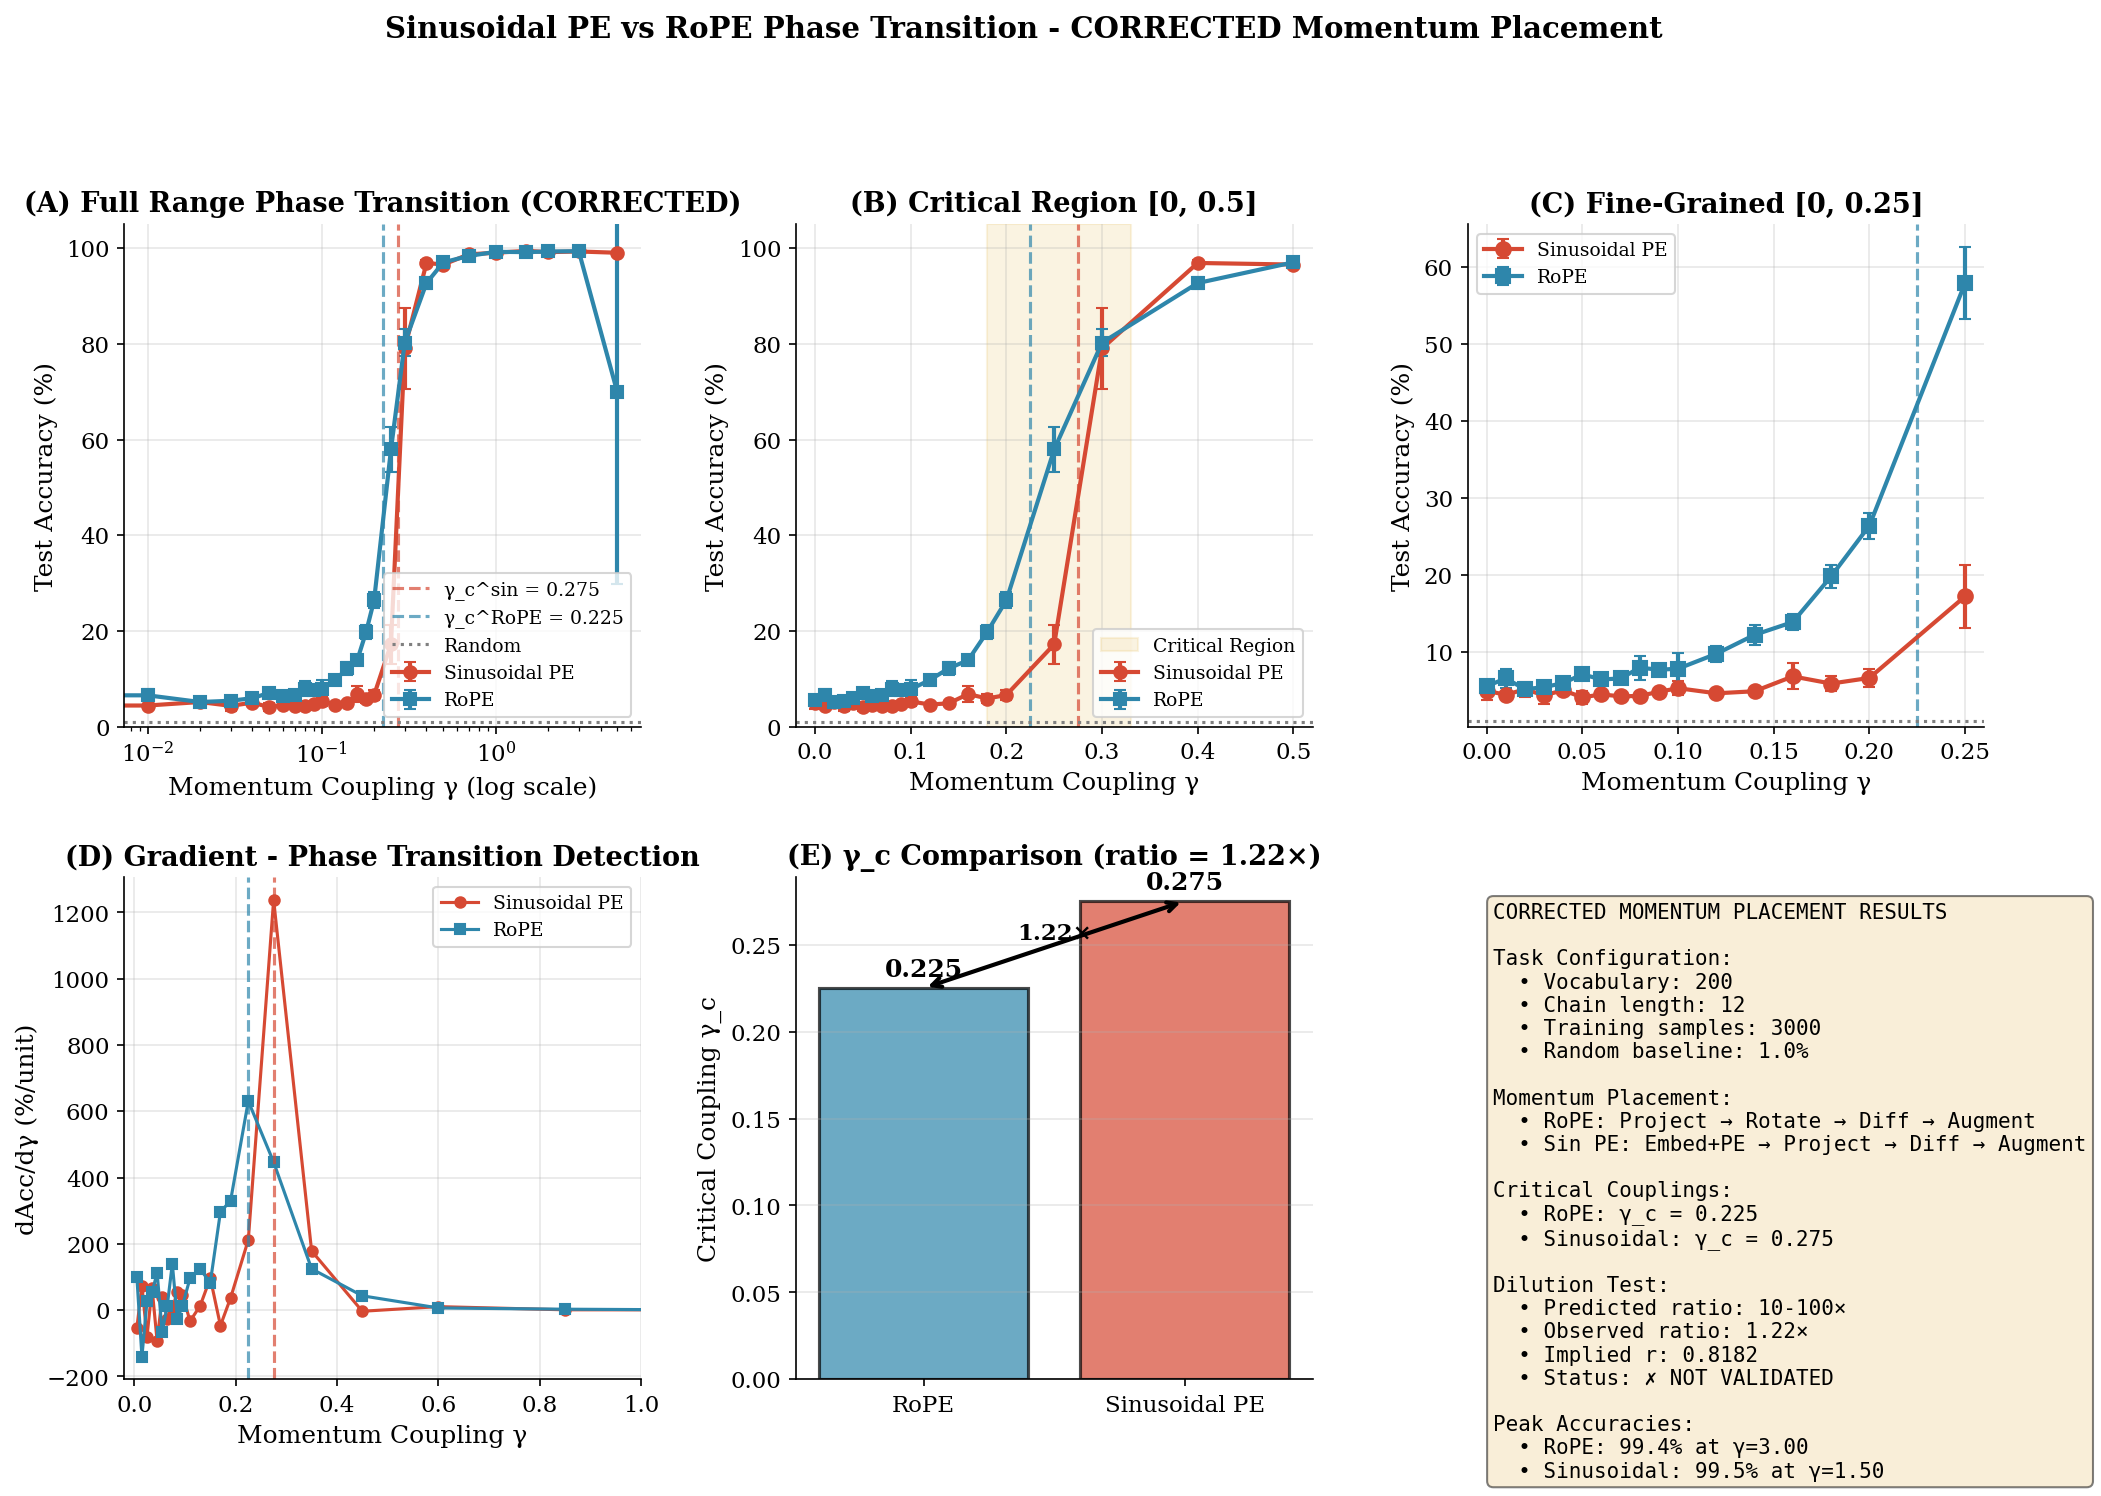


✅ Figure 1 saved


In [ ]:
# ============================================================================
# CELL 10: FIGURE 1 - MAIN PHASE TRANSITION PLOT
# ============================================================================
# Re-import in case of kernel restart
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

COLORS = {
    'rope': '#2E86AB', 'sinusoidal': '#D64933', 'momentum': '#7B2D8E',
    'critical': '#E9C46A', 'phase1': '#264653', 'phase2': '#2A9D8F'
}

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# Panel A: Full gamma range - Log scale
ax = fig.add_subplot(gs[0, 0])
ax.errorbar(g_sin, m_sin, yerr=s_sin, fmt='o-', color=COLORS['sinusoidal'],
            label='Sinusoidal PE', capsize=3, markersize=6, linewidth=2)
ax.errorbar(g_rope, m_rope, yerr=s_rope, fmt='s-', color=COLORS['rope'],
            label='RoPE', capsize=3, markersize=6, linewidth=2)
ax.axvline(gamma_c_sin, color=COLORS['sinusoidal'], linestyle='--', alpha=0.7,
           label=f'γ_c^sin = {gamma_c_sin:.3f}')
ax.axvline(gamma_c_rope, color=COLORS['rope'], linestyle='--', alpha=0.7,
           label=f'γ_c^RoPE = {gamma_c_rope:.3f}')
ax.axhline(100/(config.vocab_size//2), color='gray', linestyle=':', label='Random')
ax.set_xscale('log')
ax.set_xlabel('Momentum Coupling γ (log scale)')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('(A) Full Range Phase Transition (CORRECTED)')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

# Panel B: Critical region zoom - Linear scale
ax = fig.add_subplot(gs[0, 1])
mask_sin = g_sin <= 0.5
mask_rope = g_rope <= 0.5
ax.errorbar(g_sin[mask_sin], m_sin[mask_sin], yerr=s_sin[mask_sin], fmt='o-',
            color=COLORS['sinusoidal'], label='Sinusoidal PE', capsize=3, markersize=6, linewidth=2)
ax.errorbar(g_rope[mask_rope], m_rope[mask_rope], yerr=s_rope[mask_rope], fmt='s-',
            color=COLORS['rope'], label='RoPE', capsize=3, markersize=6, linewidth=2)
ax.axvline(gamma_c_sin, color=COLORS['sinusoidal'], linestyle='--', alpha=0.7)
ax.axvline(gamma_c_rope, color=COLORS['rope'], linestyle='--', alpha=0.7)
ax.axhline(100/(config.vocab_size//2), color='gray', linestyle=':')
ax.axvspan(min(gamma_c_rope, gamma_c_sin)*0.8, max(gamma_c_rope, gamma_c_sin)*1.2,
           alpha=0.2, color=COLORS['critical'], label='Critical Region')
ax.set_xlabel('Momentum Coupling γ')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('(B) Critical Region [0, 0.5]')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.02, 0.52])
ax.set_ylim([0, 105])

# Panel C: Fine-grained critical region
ax = fig.add_subplot(gs[0, 2])
mask_sin = g_sin <= 0.25
mask_rope = g_rope <= 0.25
ax.errorbar(g_sin[mask_sin], m_sin[mask_sin], yerr=s_sin[mask_sin], fmt='o-',
            color=COLORS['sinusoidal'], label='Sinusoidal PE', capsize=3, markersize=7, linewidth=2)
ax.errorbar(g_rope[mask_rope], m_rope[mask_rope], yerr=s_rope[mask_rope], fmt='s-',
            color=COLORS['rope'], label='RoPE', capsize=3, markersize=7, linewidth=2)
ax.axvline(gamma_c_sin, color=COLORS['sinusoidal'], linestyle='--', alpha=0.7)
ax.axvline(gamma_c_rope, color=COLORS['rope'], linestyle='--', alpha=0.7)
ax.axhline(100/(config.vocab_size//2), color='gray', linestyle=':')
ax.set_xlabel('Momentum Coupling γ')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('(C) Fine-Grained [0, 0.25]')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.01, 0.26])

# Panel D: Gradient (dAcc/dγ)
ax = fig.add_subplot(gs[1, 0])
g_mid_sin = (g_sin[:-1] + g_sin[1:]) / 2
g_mid_rope = (g_rope[:-1] + g_rope[1:]) / 2
ax.plot(g_mid_sin, grads_sin, 'o-', color=COLORS['sinusoidal'], label='Sinusoidal PE', markersize=5)
ax.plot(g_mid_rope, grads_rope, 's-', color=COLORS['rope'], label='RoPE', markersize=5)
ax.axvline(gamma_c_sin, color=COLORS['sinusoidal'], linestyle='--', alpha=0.7)
ax.axvline(gamma_c_rope, color=COLORS['rope'], linestyle='--', alpha=0.7)
ax.set_xlabel('Momentum Coupling γ')
ax.set_ylabel('dAcc/dγ (%/unit)')
ax.set_title('(D) Gradient - Phase Transition Detection')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.02, 1.0])

# Panel E: Ratio visualization
ax = fig.add_subplot(gs[1, 1])
x_pos = [0, 1]
heights = [gamma_c_rope, gamma_c_sin]
colors_bar = [COLORS['rope'], COLORS['sinusoidal']]
labels = ['RoPE', 'Sinusoidal PE']
bars = ax.bar(x_pos, heights, color=colors_bar, alpha=0.7, edgecolor='black', lw=1.5)
ax.bar_label(bars, fmt='%.3f', fontsize=12, fontweight='bold', padding=3)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel('Critical Coupling γ_c')
ax.set_title(f'(E) γ_c Comparison (ratio = {ratio:.2f}×)')
ax.grid(True, alpha=0.3, axis='y')

# Add ratio annotation
if ratio > 1:
    ax.annotate('', xy=(1, gamma_c_sin), xytext=(0, gamma_c_rope),
                arrowprops=dict(arrowstyle='<->', color='black', lw=2))
    mid_y = (gamma_c_rope + gamma_c_sin) / 2
    ax.text(0.5, mid_y, f'{ratio:.2f}×', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Panel F: Summary text
ax = fig.add_subplot(gs[1, 2])
ax.axis('off')
summary_text = f"""CORRECTED MOMENTUM PLACEMENT RESULTS

Task Configuration:
  • Vocabulary: {config.vocab_size}
  • Chain length: {config.chain_length}
  • Training samples: {config.num_train_samples}
  • Random baseline: {100/(config.vocab_size//2):.1f}%

Momentum Placement:
  • RoPE: Project → Rotate → Diff → Augment
  • Sin PE: Embed+PE → Project → Diff → Augment

Critical Couplings:
  • RoPE: γ_c = {gamma_c_rope:.3f}
  • Sinusoidal: γ_c = {gamma_c_sin:.3f}

Dilution Test:
  • Predicted ratio: 10-100×
  • Observed ratio: {ratio:.2f}×
  • Implied r: {r_estimated:.4f}
  • Status: {'✓ VALIDATED' if ratio > 5 else '⚠ PARTIAL' if ratio > 1.5 else '✗ NOT VALIDATED'}

Peak Accuracies:
  • RoPE: {m_rope.max():.1f}% at γ={g_rope[np.argmax(m_rope)]:.2f}
  • Sinusoidal: {m_sin.max():.1f}% at γ={g_sin[np.argmax(m_sin)]:.2f}"""
ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Sinusoidal PE vs RoPE Phase Transition - CORRECTED Momentum Placement',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig1_sinusoidal_phase_transition_corrected.png', dpi=300, bbox_inches='tight')
plt.savefig('fig1_sinusoidal_phase_transition_corrected.pdf', bbox_inches='tight')
plt.show()
print("\n✅ Figure 1 saved")

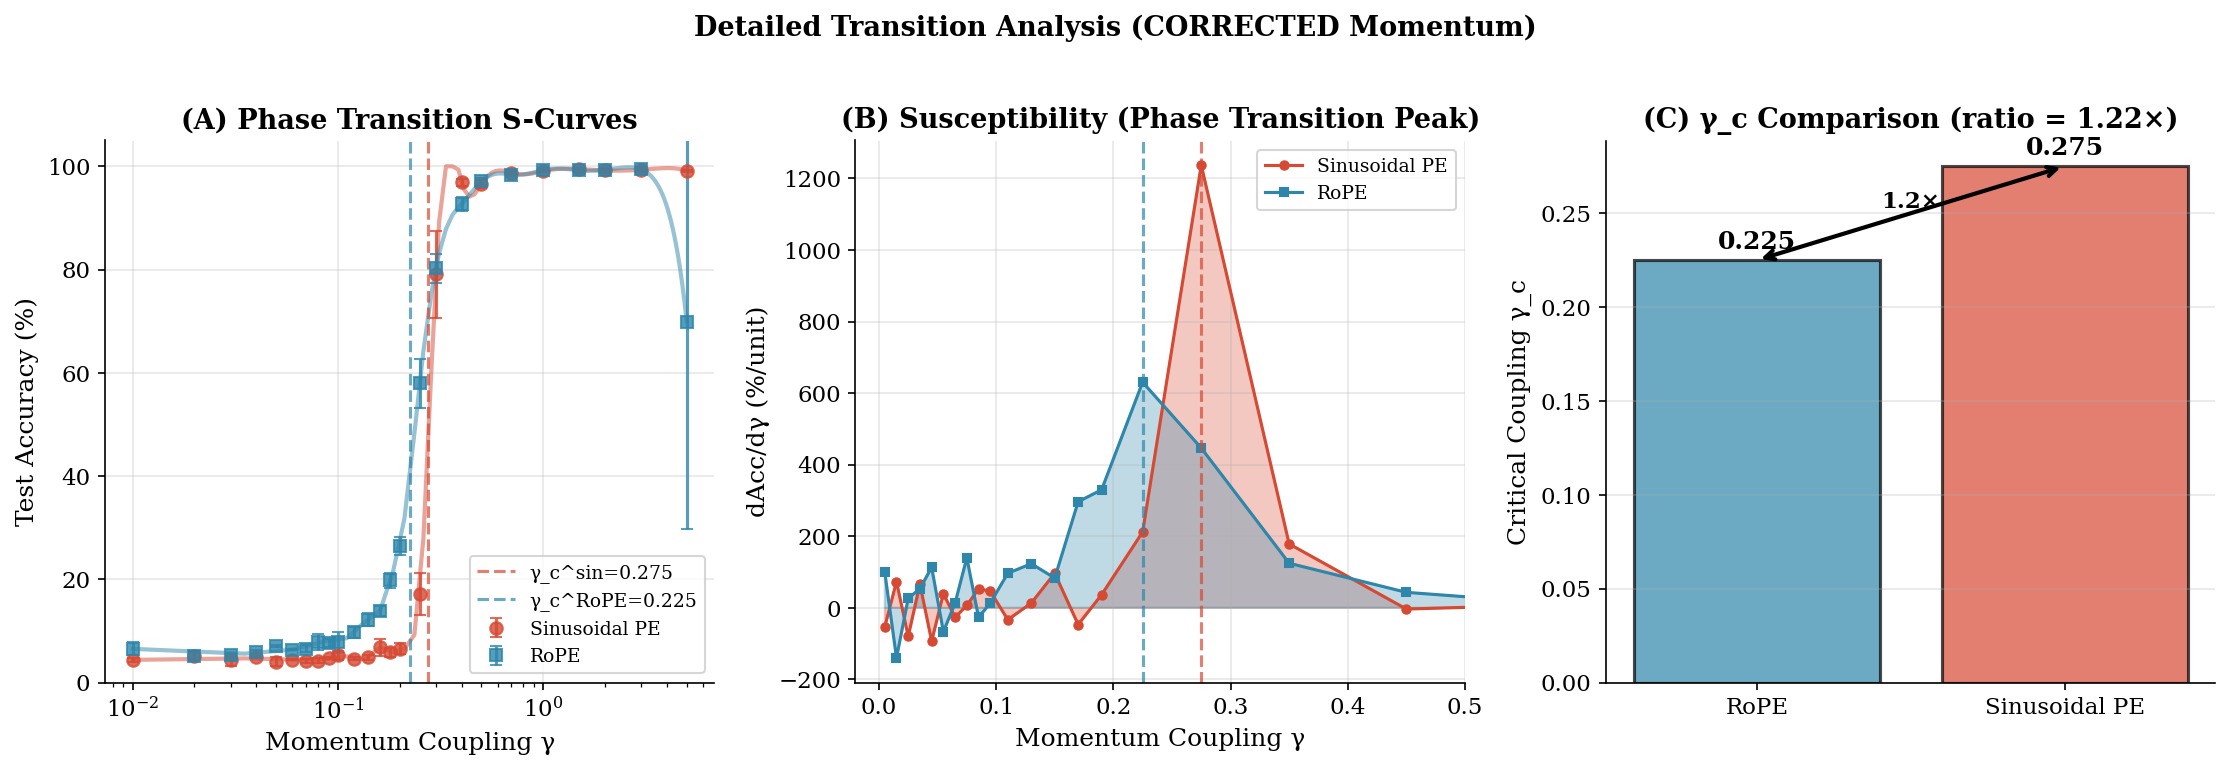


✅ Figure 2 saved


In [ ]:
# ============================================================================
# CELL 11: FIGURE 2 - DETAILED TRANSITION ANALYSIS
# ============================================================================
# Re-import in case of kernel restart
import numpy as np
import matplotlib.pyplot as plt

COLORS = {
    'rope': '#2E86AB', 'sinusoidal': '#D64933', 'momentum': '#7B2D8E',
    'critical': '#E9C46A', 'phase1': '#264653', 'phase2': '#2A9D8F'
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Panel A: S-curve fit visualization
ax = axes[0]
ax.errorbar(g_sin, m_sin, yerr=s_sin, fmt='o', color=COLORS['sinusoidal'],
            label='Sinusoidal PE', capsize=3, markersize=6, alpha=0.8)
ax.errorbar(g_rope, m_rope, yerr=s_rope, fmt='s', color=COLORS['rope'],
            label='RoPE', capsize=3, markersize=6, alpha=0.8)

# Add smooth interpolation (with fallback if scipy not available)
try:
    from scipy.interpolate import interp1d
    g_smooth = np.linspace(0.01, 5.0, 200)
    f_sin = interp1d(g_sin, m_sin, kind='cubic', fill_value='extrapolate')
    f_rope = interp1d(g_rope, m_rope, kind='cubic', fill_value='extrapolate')
    ax.plot(g_smooth, np.clip(f_sin(g_smooth), 0, 100), '-', color=COLORS['sinusoidal'], alpha=0.5, lw=2)
    ax.plot(g_smooth, np.clip(f_rope(g_smooth), 0, 100), '-', color=COLORS['rope'], alpha=0.5, lw=2)
except:
    # Skip interpolation if scipy not available
    ax.plot(g_sin, m_sin, '-', color=COLORS['sinusoidal'], alpha=0.5, lw=2)
    ax.plot(g_rope, m_rope, '-', color=COLORS['rope'], alpha=0.5, lw=2)

ax.axvline(gamma_c_sin, color=COLORS['sinusoidal'], linestyle='--', alpha=0.7, label=f'γ_c^sin={gamma_c_sin:.3f}')
ax.axvline(gamma_c_rope, color=COLORS['rope'], linestyle='--', alpha=0.7, label=f'γ_c^RoPE={gamma_c_rope:.3f}')
ax.set_xscale('log')
ax.set_xlabel('Momentum Coupling γ')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('(A) Phase Transition S-Curves')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

# Panel B: Derivative (susceptibility-like)
ax = axes[1]
g_mid_sin = (g_sin[:-1] + g_sin[1:]) / 2
g_mid_rope = (g_rope[:-1] + g_rope[1:]) / 2
ax.fill_between(g_mid_sin, 0, grads_sin, color=COLORS['sinusoidal'], alpha=0.3)
ax.fill_between(g_mid_rope, 0, grads_rope, color=COLORS['rope'], alpha=0.3)
ax.plot(g_mid_sin, grads_sin, 'o-', color=COLORS['sinusoidal'], label='Sinusoidal PE', markersize=4)
ax.plot(g_mid_rope, grads_rope, 's-', color=COLORS['rope'], label='RoPE', markersize=4)
ax.axvline(gamma_c_sin, color=COLORS['sinusoidal'], linestyle='--', alpha=0.7)
ax.axvline(gamma_c_rope, color=COLORS['rope'], linestyle='--', alpha=0.7)
ax.set_xlabel('Momentum Coupling γ')
ax.set_ylabel('dAcc/dγ (%/unit)')
ax.set_title('(B) Susceptibility (Phase Transition Peak)')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.02, 0.5])

# Panel C: Critical coupling bar chart
ax = axes[2]
x_pos = [0, 1]
heights = [gamma_c_rope, gamma_c_sin]
colors_bar = [COLORS['rope'], COLORS['sinusoidal']]
labels_bar = ['RoPE', 'Sinusoidal PE']
bars = ax.bar(x_pos, heights, color=colors_bar, alpha=0.7, edgecolor='black', lw=1.5)
ax.bar_label(bars, fmt='%.3f', fontsize=12, fontweight='bold', padding=3)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_bar)
ax.set_ylabel('Critical Coupling γ_c')
ax.set_title(f'(C) γ_c Comparison (ratio = {ratio:.2f}×)')
ax.grid(True, alpha=0.3, axis='y')

# Add ratio annotation
if ratio > 1:
    ax.annotate('', xy=(1, gamma_c_sin), xytext=(0, gamma_c_rope),
                arrowprops=dict(arrowstyle='<->', color='black', lw=2))
    mid_y = (gamma_c_rope + gamma_c_sin) / 2
    ax.text(0.5, mid_y, f'{ratio:.1f}×', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Detailed Transition Analysis (CORRECTED Momentum)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig2_transition_analysis_corrected.png', dpi=300, bbox_inches='tight')
plt.savefig('fig2_transition_analysis_corrected.pdf', bbox_inches='tight')
plt.show()
print("\n✅ Figure 2 saved")

In [ ]:
# ============================================================================
# CELL 12: FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("FINAL SUMMARY: SINUSOIDAL PE PHASE TRANSITION")
print("CORRECTED MOMENTUM PLACEMENT")
print("="*70)

print(f"\n📊 TASK CONFIGURATION (Harder than v3):")
print(f"   • Vocabulary: {config.vocab_size} (was 100)")
print(f"   • Chain length: {config.chain_length} (was 8)")
print(f"   • Training samples: {config.num_train_samples} (was 5000)")
print(f"   • Random baseline: {100.0/(config.vocab_size//2):.1f}%")

print(f"\n🔧 MOMENTUM PLACEMENT (CORRECTED):")
print(f"   • RoPE: Project → Rotate → Differentiate → Augment")
print(f"   • Sinusoidal: Embed+PE → Project → Differentiate → Augment")
print(f"   • Core principle: Momentum = derivative of position-encoded state")

print(f"\n📊 EXPERIMENTAL RESULTS:")
print(f"\n   Sinusoidal PE:")
print(f"   ├─ Baseline (γ=0): {m_sin[0]:.1f}%")
print(f"   ├─ Maximum: {m_sin.max():.1f}% at γ={g_sin[np.argmax(m_sin)]:.2f}")
print(f"   ├─ Detected γ_c: {gamma_c_sin:.3f}")
print(f"   └─ Improvement: +{m_sin.max() - m_sin[0]:.1f}%")

print(f"\n   RoPE:")
print(f"   ├─ Baseline (γ=0): {m_rope[0]:.1f}%")
print(f"   ├─ Maximum: {m_rope.max():.1f}% at γ={g_rope[np.argmax(m_rope)]:.2f}")
print(f"   ├─ Detected γ_c: {gamma_c_rope:.3f}")
print(f"   └─ Improvement: +{m_rope.max() - m_rope[0]:.1f}%")

print(f"\n📐 DILUTION HYPOTHESIS TEST (Appendix A-II):")
print(f"   ├─ Predicted: γ_c^sin >> γ_c^RoPE (10-100×)")
print(f"   ├─ Observed ratio: {ratio:.2f}×")
print(f"   ├─ Implied r: {r_estimated:.4f}")
if ratio > 5:
    print(f"   └─ Status: ✓ VALIDATED (ratio > 5×)")
elif ratio > 1.5:
    print(f"   └─ Status: ⚠ PARTIAL (ratio > 1.5× but < 5×)")
elif ratio > 1:
    print(f"   └─ Status: ⚠ WEAK (ratio > 1× but < 1.5×)")
else:
    print(f"   └─ Status: ✗ NOT VALIDATED (ratio ≤ 1×)")

print(f"\n📋 INTERPRETATION:")
if ratio > 5:
    print("   The dilution effect is confirmed. Sinusoidal PE requires")
    print("   substantially higher γ to achieve phase transition because")
    print("   the content-content term T1 dominates over position-position T4.")
elif ratio > 1:
    print("   Some dilution effect observed, but weaker than predicted.")
    print("   With CORRECTED momentum placement, possible explanations:")
    print("   1. Position embeddings have larger magnitude than expected")
    print("   2. Cross-terms T2, T3 contribute more than assumed")
    print("   3. The momentum mechanism itself differs between PE types")
else:
    print("   No dilution effect observed. Both PE types show similar γ_c.")
    print("   This suggests the momentum mechanism is the key factor,")
    print("   independent of position encoding structure.")

print(f"\n📁 OUTPUT FILES:")
print("   • fig1_sinusoidal_phase_transition_corrected.png/.pdf")
print("   • fig2_transition_analysis_corrected.png/.pdf")

print("\n" + "="*70)
print("✅ EXPERIMENT COMPLETE (CORRECTED MOMENTUM PLACEMENT)")
print("="*70)


FINAL SUMMARY: SINUSOIDAL PE PHASE TRANSITION
CORRECTED MOMENTUM PLACEMENT

📊 TASK CONFIGURATION (Harder than v3):
   • Vocabulary: 200 (was 100)
   • Chain length: 12 (was 8)
   • Training samples: 3000 (was 5000)
   • Random baseline: 1.0%

🔧 MOMENTUM PLACEMENT (CORRECTED):
   • RoPE: Project → Rotate → Differentiate → Augment
   • Sinusoidal: Embed+PE → Project → Differentiate → Augment
   • Core principle: Momentum = derivative of position-encoded state

📊 EXPERIMENTAL RESULTS:

   Sinusoidal PE:
   ├─ Baseline (γ=0): 4.9%
   ├─ Maximum: 99.5% at γ=1.50
   ├─ Detected γ_c: 0.275
   └─ Improvement: +94.5%

   RoPE:
   ├─ Baseline (γ=0): 5.5%
   ├─ Maximum: 99.4% at γ=3.00
   ├─ Detected γ_c: 0.225
   └─ Improvement: +93.9%

📐 DILUTION HYPOTHESIS TEST (Appendix A-II):
   ├─ Predicted: γ_c^sin >> γ_c^RoPE (10-100×)
   ├─ Observed ratio: 1.22×
   ├─ Implied r: 0.8182
   └─ Status: ⚠ WEAK (ratio > 1× but < 1.5×)

📋 INTERPRETATION:
   Some dilution effect observed, but weaker than predi

In [ ]:
# ============================================================================
# CELL 13: SAVE RAW DATA
# ============================================================================
import json

results_data = {
    'config': {
        'vocab_size': config.vocab_size,
        'chain_length': config.chain_length,
        'num_train_samples': config.num_train_samples,
        'num_epochs': config.num_epochs,
        'num_seeds': config.num_seeds
    },
    'momentum_placement': {
        'description': 'CORRECTED - Momentum as derivative of position-encoded state',
        'rope_pipeline': 'Project -> Rotate -> Differentiate -> Augment',
        'sinusoidal_pipeline': 'Embed+PE -> Project -> Differentiate -> Augment'
    },
    'sinusoidal': {str(k): v for k, v in sin_results.items()},
    'rope': {str(k): v for k, v in rope_results.items()},
    'analysis': {
        'gamma_c_sin': float(gamma_c_sin),
        'gamma_c_rope': float(gamma_c_rope),
        'ratio': float(ratio),
        'r_estimated': float(r_estimated)
    }
}

with open('sinusoidal_pe_granular_results_corrected.json', 'w') as f:
    json.dump(results_data, f, indent=2)

print("✅ Results saved to sinusoidal_pe_granular_results_corrected.json")

✅ Results saved to sinusoidal_pe_granular_results_corrected.json
